## Machine Learning Project Framework

## 1. Problem Definition
- **Define the Task:**  
  - Identify if the problem is classification, regression, clustering, time series forecasting, or anomaly detection.
- **Establish Objectives:**  
  - Clarify the business or research goals.
- **Determine Success Metrics:**  
  - For classification: accuracy, precision, recall, F1-score, AUC-ROC.
  - For regression: RMSE, MAE, R².
  - For clustering: silhouette score, Davies-Bouldin index.
  - For time series: MAPE, RMSE.
  - For anomaly detection: precision, recall, F1-score.

In [47]:
"""This is a regression task as we are trying to predict the price of backpacks based on their features.
The success metric is going to be RMSE (Root Mean Squared Error)"""

'This is a regression task as we are trying to predict the price of backpacks based on their features.\nThe success metric is going to be RMSE (Root Mean Squared Error)'

In [48]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

## 2. Data Collection & Understanding
- **Data Acquisition:**  
  - Gather data from sources like internal databases, APIs, web scraping, or external datasets.
- **Initial Data Inspection:**  
  - Load the data and inspect its structure (e.g., using `data.info()`, `data.head()`, `data.nunique()`, and etc.).
- **Quality Assessment:**  
  - Identify missing values, duplicates, and inconsistencies.

In [49]:
train = pd.read_csv('train.csv')
train2 = pd.read_csv('training_extra.csv')
test = pd.read_csv('test.csv')


# Let's merge the two training datasets
train = pd.concat([train, train2], ignore_index=True)
train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
3994313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3994314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3994315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3994316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


In [50]:
# we can drop the id column as it is not useful for the model
# train = train.drop('id', axis=1)
# test = test.drop('id', axis=1)

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB


In [52]:
train.nunique()

id                      3994318
Brand                         5
Material                      4
Size                          3
Compartments                 10
Laptop Compartment            2
Waterproof                    2
Style                         3
Color                         6
Weight Capacity (kg)    1920345
Price                     48358
dtype: int64

In [53]:
# changing columns to the correct data types
categorical_columns = ['Brand','Material','Size','Laptop Compartment','Waterproof','Style','Color']
for col in categorical_columns:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

train['Compartments'] = train['Compartments'].astype('int')
test['Compartments'] = test['Compartments'].astype('int')

In [54]:
# lets check for duplicates
print("Number of duplicates in train data:", train.duplicated().sum())

Number of duplicates in train data: 0


In [55]:
# lets check missing values
print("Percent of missing values in train data:")
train.isnull().sum()/len(train)*100

Percent of missing values in train data:


id                      0.000000
Brand                   3.173458
Material                2.777996
Size                    2.197747
Compartments            0.000000
Laptop Compartment      2.466829
Waterproof              2.361454
Style                   2.608205
Color                   3.345177
Weight Capacity (kg)    0.045264
Price                   0.000000
dtype: float64

In [56]:
# it is important to understand the missing values and why they are missing. 
# For example, if the missing values are due to the fact that the feature is not applicable to the product,
# then it is important to keep the missing values as a separate category.

missing_rows = train[train.isnull().any(axis=1)]
missing_rows

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
5,5,Nike,Canvas,Medium,10,No,Yes,NaN,Black,7.241812,20.01553
6,6,Nike,NaN,Large,3,No,No,Backpack,Green,6.828123,84.80500
10,10,Nike,Polyester,Large,1,Yes,No,Backpack,NaN,27.806951,68.31047
11,11,Nike,Polyester,NaN,10,No,No,NaN,Gray,13.697554,23.25963
21,21,Under Armour,Polyester,NaN,9,Yes,Yes,Messenger,Gray,11.219052,35.46348
...,...,...,...,...,...,...,...,...,...,...,...
3994294,4194294,NaN,Nylon,Large,6,No,No,Messenger,Black,22.170745,60.09724
3994308,4194308,Adidas,NaN,Large,5,Yes,Yes,Messenger,Gray,12.370109,18.99152
3994310,4194310,Adidas,Nylon,Small,10,No,NaN,Tote,Red,22.959725,128.51754
3994313,4194313,Nike,Canvas,NaN,3,Yes,Yes,Messenger,Blue,28.098120,104.74460


## 3. Exploratory Data Analysis (EDA)
- **Data Visualization:**  
  - Create histograms, box plots, and KDE plots to understand distributions.
- **Correlation Analysis:**  
  - Generate heatmaps and pair plots to identify relationships between variables.
- **Outlier Detection:**  
  - Apply methods such as Z-score or IQR to detect anomalies.
- **Deeper Insights:**  
  - Conduct additional statistical analyses to uncover trends or patterns.

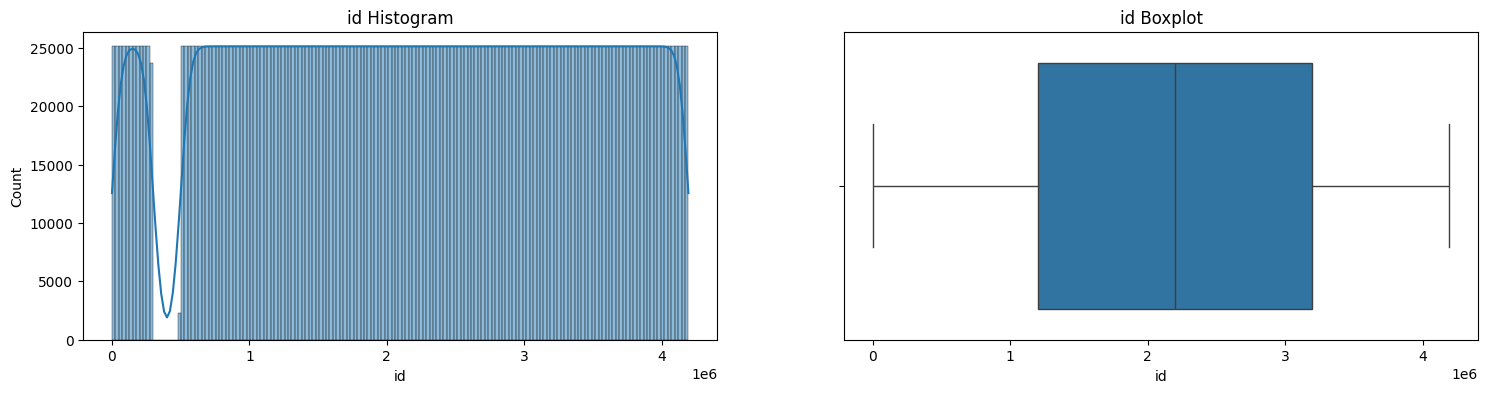

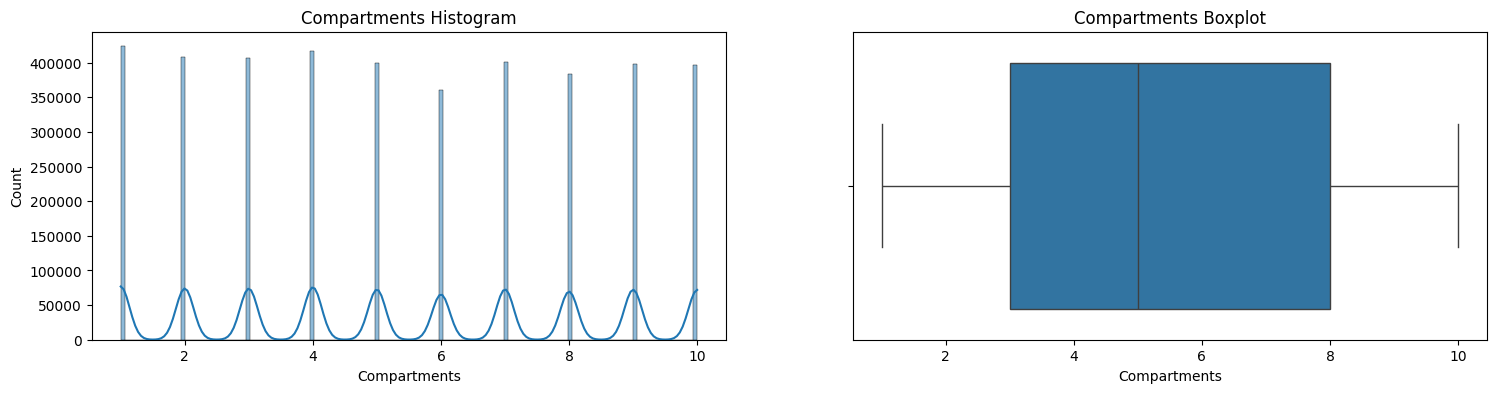

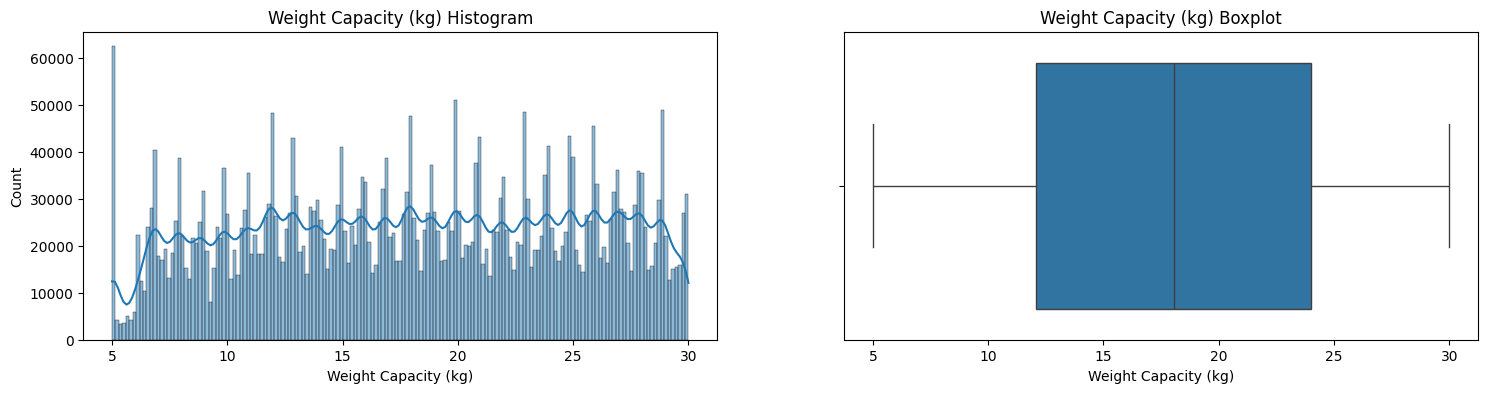

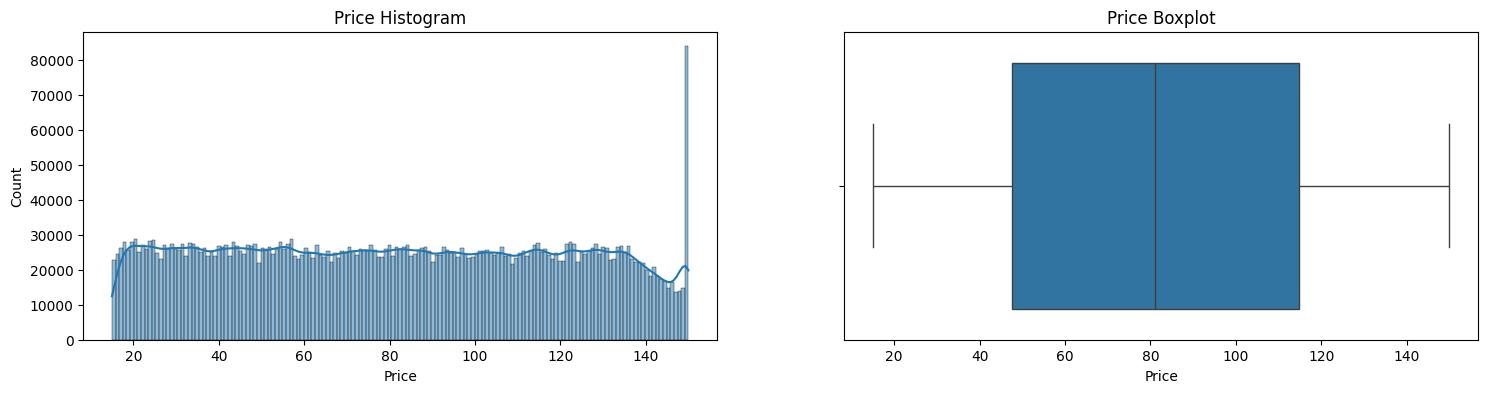

In [57]:
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))

    # Histogram
    sns.histplot(train[col], ax=axes[0], kde=True)
    axes[0].set_title(f'{col} Histogram')

    # Box plot
    sns.boxplot(x=train[col], ax=axes[1])
    axes[1].set_title(f'{col} Boxplot')
    plt.show()

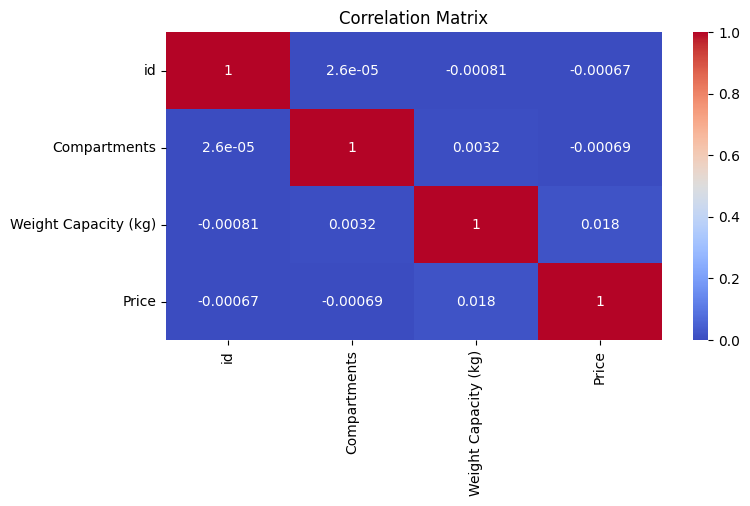

In [58]:
# lets do a correlation matrix plot
numerical_columns
correlation_matrix = train[numerical_columns].corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

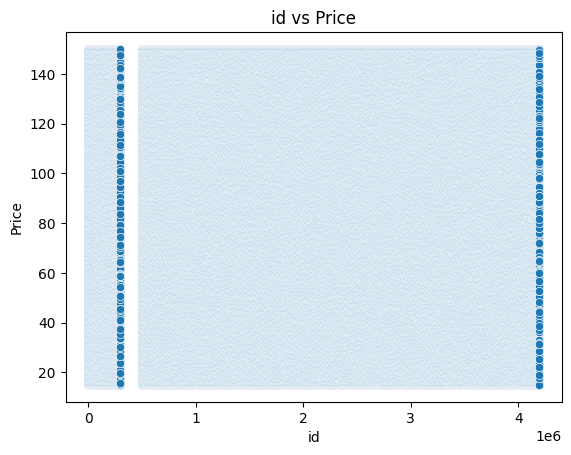

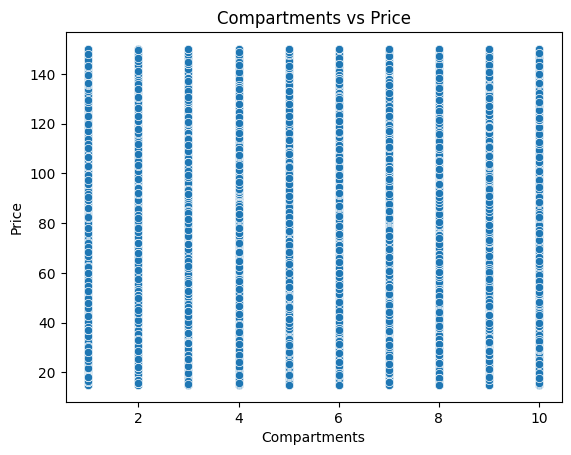

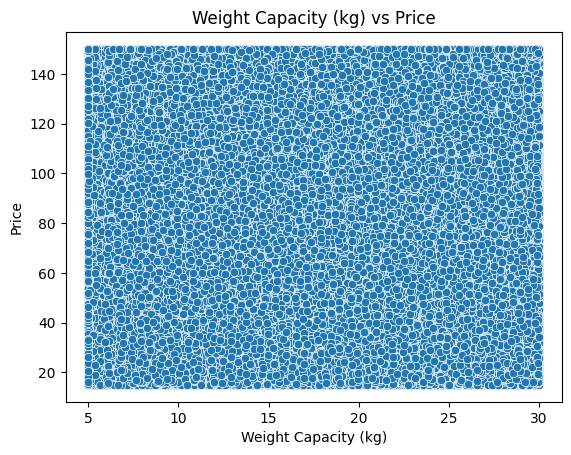

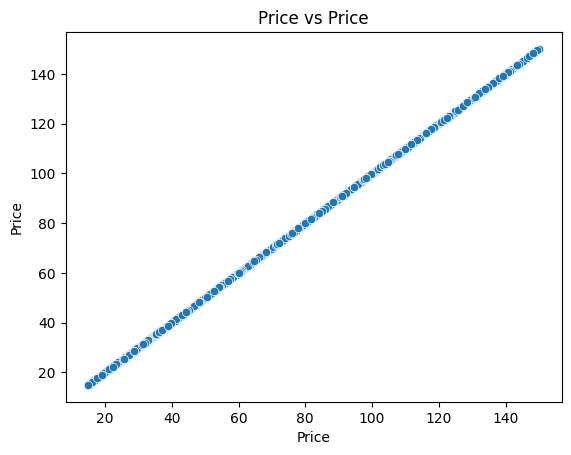

In [59]:
# lets look at scatter plots for the numerical columns
for col in numerical_columns:
    sns.scatterplot(x=train[col], y=train['Price'])
    plt.title(f'{col} vs Price')
    plt.show()

## 4. Data Preprocessing & Feature Engineering
- **Handling Missing Values:**  
  - Impute or remove missing data based on context.
- **Encoding Categorical Variables:**  
  - Use one-hot encoding or label encoding.
- **Scaling Numerical Features:**  
  - Apply StandardScaler, MinMaxScaler, or other scaling methods.
- **Feature Selection and Creation:**  
  - Select important features using techniques like RFE or mutual information.
  - Create new features through aggregations, ratios, or domain-specific transformations.
- **Dataset Splitting:**  
  - Divide the data into training, validation, and testing sets.

In [60]:
# i'm just going to drop the missing values
train = train.dropna()

In [61]:
# splitting data into train and test
X = train.drop('Price', axis=1)
y = train['Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Model Selection & Training
- **Baseline Models:**  
  - Choose simple models (e.g., Logistic Regression, Linear Regression) as a starting point.
- **Advanced Models:**  
  - Consider ensemble methods, neural networks, or specialized models based on the problem.
- **Hyperparameter Tuning:**  
  - Use techniques like GridSearchCV, RandomizedSearchCV, or Bayesian Optimization.
- **Cross-Validation:**  
  - Employ k-Fold for most tasks or TimeSeriesSplit for time series data.

In [62]:
model = XGBRegressor(enable_categorical=True)

model.fit(X_train, y_train)

# cross validation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mes_scores = -scores
rmse_scores = np.sqrt(mes_scores)

## 6. Model Evaluation & Interpretation
- **Performance Metrics:**  
  - Evaluate using the appropriate metrics based on the problem type.
- **Error Analysis:**  
  - Review misclassified cases or high residual errors.
- **Model Interpretation:**  
  - Use tools like SHAP values or permutation importance to understand feature contributions.

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 38.78826190430053


In [64]:
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

R2: 0.0010931761449011201


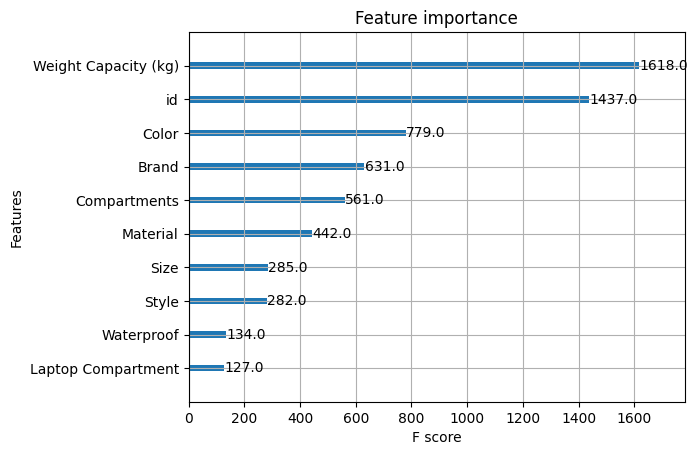

In [65]:
xgb.plot_importance(model)
plt.show()

In [ ]:
# kaggle_predictions = model.predict(test)

# submission = pd.DataFrame({
#     'id': test['id'],
#     'Price': kaggle_predictions
# })

In [ ]:
# submission.to_csv('submission.csv', index=False)

## 7. Deployment & Monitoring
- **Model Saving:**  
  - Persist models using joblib, pickle, or ONNX.
- **Deployment as an API:**  
  - Use frameworks like Flask, FastAPI, or cloud services (e.g., AWS Lambda).
- **Monitoring:**  
  - Track model performance and drift, and set up alerts for retraining triggers.

In [67]:
joblib.dump(model, 'model.pkl')

# Load the model
# model = joblib.load("xgb_model.pkl")

['model.pkl']

## 8. Iteration & Improvement
- **Review and Refine:**  
  - Continuously analyze errors and update features or models.
- **Experiment with Different Approaches:**  
  - Explore ensemble methods, deep learning models, or alternative algorithms.
- **Automate Retraining:**  
  - Implement CI/CD pipelines to update the model as new data becomes available.